In [31]:
import os

os.environ["PYSPARK_SUBMIT_ARGS"] = "--jars /Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/assets/sqlite-jdbc-3.49.1.0.jar pyspark-shell"

👆 This cell had to be the first cell according to the troubleshooting research I did. Environment setup nightmares.

# Cross-Platform Reporting with Spark

author: Aaron Gillespie  
date: 2025-04-11

# Purpose

This code base is being created in the course of completing module 5 of CSIS 44-643 from NW Missouri University. In this module we are learning about **spark** for reporting against a data warehouse. The data warehouse we'll use is minimal - the one we've built over the past few weeks based in _sqlite_.

In [32]:
from pyspark.sql import SparkSession

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

## Task 1: Setup the Environment

Followed these steps:

1. Install Apache Spark
2. Download the SQLite JDBC Driver from https://github.com/xerial/sqlite-jdbc
3. Follow the Usage instructions in the README. Download the .jar file. I make a lib folder in my project repository and put it there. 
4. Set up SQLite JDBC Driver
5. Verify PySpark works in Jupyter Notebook

Verification:

In [33]:
# Verify Spark works
spark = SparkSession.builder.appName("SmartSales").getOrCreate()

print(spark.sparkContext._conf.get("spark.jars"))

file:///Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/assets/sqlite-jdbc-3.49.1.0.jar


## Task 2: Connect to the Data Warehouse

Getting this connection to happen was a bit of a nightmare. JDBC drivers did NOT work until the 2nd ".config" line and the 3rd ".option" line were _both_ added. 

In [34]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SmartSales") \
    .config("spark.jars", "/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/assets/sqlite-jdbc-3.49.1.0.jar") \
    .config("spark.driver.extraClassPath", "/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/assets/sqlite-jdbc-3.49.1.0.jar") \
    .getOrCreate()

df_sales = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/data/dw/smart_sales.db") \
    .option("dbtable", "sales") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_sales.show()

+-------------+----------+---------+-------+----------+----------+----------+---------------+--------+---------+
|TransactionID|CustomerID|ProductID|StoreID|CampaignID|SaleAmount|  SaleDate|          State|Discount|StateCode|
+-------------+----------+---------+-------+----------+----------+----------+---------------+--------+---------+
|          550|      1008|      102|    404|         0|      39.1|2024-01-06|     California|   15.04|       CA|
|          551|      1009|      105|    403|         0|     19.78|2024-01-06|          Texas|    5.54|       TX|
|          552|      1004|      107|    404|         0|     335.1|2024-01-16|        Florida|    26.5|       FL|
|          553|      1006|      102|    406|         0|     195.5|2024-01-16|       New York|    34.3|       NY|
|          554|      1005|      102|    405|         0|     117.3|2024-01-25|   Pennsylvania|   34.18|       PA|
|          555|      1001|      101|    401|         0|   2379.36|2024-01-25|       Illinois|  3

Now that we can load in data, let's load in the other tables.

In [35]:
df_customers = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/data/dw/smart_sales.db") \
    .option("dbtable", "customers") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_stores = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/data/dw/smart_sales.db") \
    .option("dbtable", "stores") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_campaigns = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/data/dw/smart_sales.db") \
    .option("dbtable", "campaigns") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_products = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/data/dw/smart_sales.db") \
    .option("dbtable", "products") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_suppliers = spark.read.format("jdbc") \
    .option("url", "jdbc:sqlite:/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/data/dw/smart_sales.db") \
    .option("dbtable", "suppliers") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

# Show the dataframes to ensure they are loaded correctly
df_customers.show()
df_stores.show()
df_campaigns.show()
df_products.show()
df_suppliers.show()

+----------+----------------+------+--------+----------------+-----------------+----------+
|CustomerID|            Name|Region|JoinDate|StandardJoinDate|ReferringCustomer|  Birthday|
+----------+----------------+------+--------+----------------+-----------------+----------+
|      1001|   William White|  East|11/11/21|      2021-11-11|             1004|2002-04-22|
|      1002|    Wylie Coyote|  East| 2/14/23|      2023-02-14|             NULL|1949-05-01|
|      1003|       Dan Brown|  West|10/19/23|      2023-10-19|             NULL|1964-06-22|
|      1004|       Chewbacca|  West| 11/9/22|      2022-11-09|             1007|1977-05-25|
|      1007|   Susan Johnson| South| 6/30/23|      2023-06-30|             NULL|1927-11-13|
|      1008|      Tony Stark| North|  5/1/20|      2020-05-01|             NULL|1963-12-18|
|      1009|    Jason Bourne|  West| 12/1/20|      2020-12-01|             1010|2002-08-04|
|      1010|Hermione Granger|  East| 12/9/22|      2022-12-09|             NULL|

## Task 3 Query & Aggregate Data

In [36]:
# Register DataFrames as temporary views
df_sales.createOrReplaceTempView("sales")
df_customers.createOrReplaceTempView("customers")

# Write query using Spark SQL
df_top_customers = spark.sql("""
SELECT c.Name AS name, SUM(s.SaleAmount) AS total_spent
FROM sales s
JOIN customers c ON s.CustomerID = c.CustomerID
GROUP BY c.Name
ORDER BY total_spent DESC
""")

# Show Spark results
df_top_customers.show()

# Convert to Pandas for use with charts
df_top_customers_pd = df_top_customers.toPandas()

+----------------+------------------+
|            name|       total_spent|
+----------------+------------------+
|   William White|23752.520000000004|
|Hermione Granger|          22822.54|
|   Susan Johnson|           12422.6|
|       Chewbacca|11813.439999999999|
| Hermione Grager|           8750.94|
|    Wylie Coyote|           7434.44|
|       Dan Brown|2427.2999999999997|
|    Jason Bourne|           1806.34|
|      Tony Stark|           1545.54|
+----------------+------------------+



## Task 4: Slice, Dice, & Drilldown

In [37]:

df_filtered = df_sales.filter(df_sales.SaleDate >= "2023-01-01")

df_sales.sort("StoreID").groupby("StoreID","CampaignID").sum("SaleAmount").show()


+-------+----------+------------------+
|StoreID|CampaignID|   sum(SaleAmount)|
+-------+----------+------------------+
|    401|         0|18713.980000000007|
|    401|         2|7444.5199999999995|
|    401|         3|           6344.96|
|    402|         0|29823.559999999998|
|    402|         2|             387.9|
|    402|         3|             45.52|
|    403|         0|1996.1599999999999|
|    403|         1|           1586.24|
|    403|         2|            651.24|
|    404|         0|           5710.78|
|    404|         1|           7569.08|
|    404|         2|             79.12|
|    405|         0|12781.960000000001|
|    405|         1|            603.18|
|    405|         3|3102.3199999999997|
|    406|         0|           11020.5|
|    406|         1|            695.32|
+-------+----------+------------------+



In [38]:

df_sales.groupby("StateCode").sum("SaleAmount").show()

+---------+------------------+
|StateCode|   sum(SaleAmount)|
+---------+------------------+
|       AZ|            320.24|
|       SC|           1070.04|
|       LA|           7525.98|
|       MN|            481.24|
|       OR|209.39999999999998|
|       VA|           6384.06|
|       RI|            715.72|
|       KY|           7138.08|
|       WY|           1267.82|
|       NH|            603.18|
|       MI|           1512.66|
|       NV|           6470.56|
|       WI|            861.78|
|       ID|              78.2|
|       CA|            118.22|
|       CT|1460.2199999999998|
|       NE|242.34000000000003|
|       MT|           7396.68|
|       NC|           7450.88|
|       VT|              98.9|
+---------+------------------+
only showing top 20 rows



# Task 5: Create Interactive Visualizations

Creating a simple bar chart of the top customers.

/var/folders/hk/h6rz0nm939n_y0ssynfrg63r0000gn/T/ipykernel_44109/761138497.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_customers_pd, x='name', y='total_spent', palette='viridis')


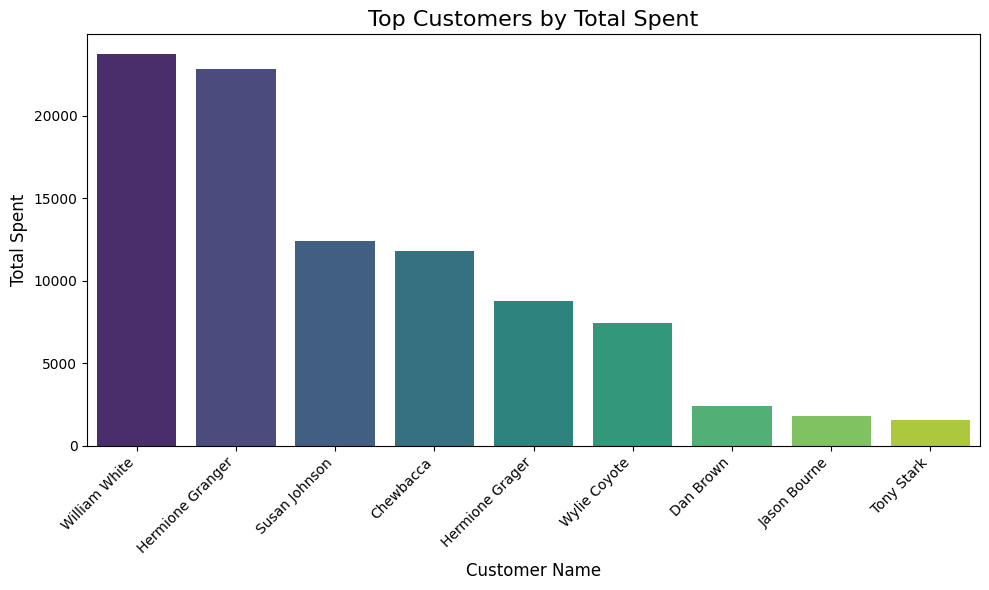

In [39]:


# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_customers_pd, x='name', y='total_spent', palette='viridis')

# Customize the chart
plt.title('Top Customers by Total Spent', fontsize=16)
plt.xlabel('Customer Name', fontsize=12)
plt.ylabel('Total Spent', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

And a line chart to show sales trends.

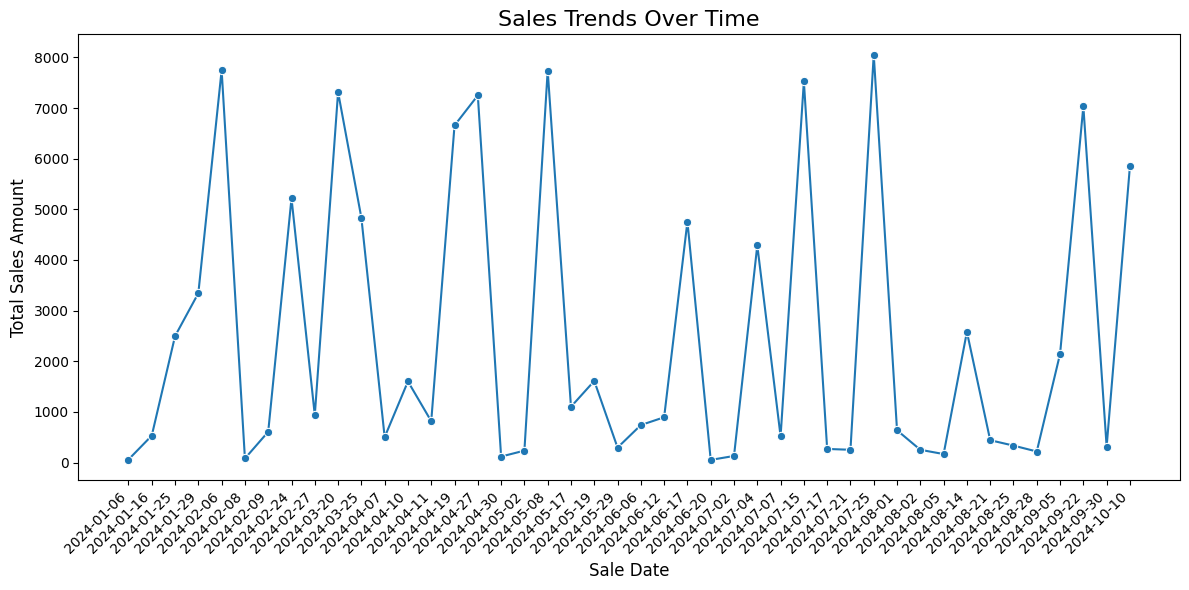

In [40]:
# Aggregate sales data by SaleDate
df_sales_by_date = df_sales.groupBy("SaleDate").sum("SaleAmount").orderBy("SaleDate")

# Convert to Pandas DataFrame for visualization
df_sales_by_date_pd = df_sales_by_date.toPandas()

# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sales_by_date_pd, x='SaleDate', y='sum(SaleAmount)', marker='o')

# Customize the chart
plt.title('Sales Trends Over Time', fontsize=16)
plt.xlabel('Sale Date', fontsize=12)
plt.ylabel('Total Sales Amount', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()